# Bonus1: Parallel Algorithms: Federated Averaging

### Name: [Yupeng Cao]
### ID: 10454637


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.09968395 -0.03853002 -0.01209403 -0.06312    -0.0276443  -0.08810576
  -0.11239601 -0.00932142]]
test std = 
[[0.99111918 1.0809159  1.10632798 0.9795742  0.89545737 1.12290051
  0.82129688 0.92241848]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [5]:
"""
Some code and Function/Variable naming is refering from HW1.
"""

class Worker:
    
    def __init__(self, x, y):
        self.x = x #s-by-d
        self.y = y #s-by-1
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((d, 1)) #d-by-1
    
    # Set the model parameters to the latest
    def set_param(self, w):
        self.w = w 
        
    # Compute the local loss    
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s-by-d 
        yxw = numpy.dot(yx, self.w) #s-by-1
        vec1 = numpy.exp(-yxw) #s-by-1
        vec2 = numpy.log(1 + vec1) #s-by-1
        return numpy.sum(vec2)         
    
    # Compute local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(yxw) # s−by−1 matrix
        vec2 = numpy.divide(yx, 1+vec1) # s−by−d matrix
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
        return g
    
    # Compute gradient descent
    def grad_descent(self, stepsize):
        g = self.gradient() 
        self.w -= stepsize * g 
        
        return self.w
    
    # Compute local gradient for SGD
    def stochastic_objective_gradient(self, w, xi, yi, lam):
        d = xi.shape[0] 
        yx = yi * xi #1-by-d
        yxw = float(numpy.dot(yx, w)) #scalar
        
        loss = numpy.log(1 + numpy.exp(-yxw)) #scalar
        reg = lam / 2 * numpy.sum(w * w)
        obj = loss + reg
        
        g_loss = -yx.T / (1 + numpy.exp(yxw)) #d-by-1
        g = g_loss + lam * w #d-by-1
        
        return obj, g
    
    # Compute local gradient descent for SGD
    def sgd(self, stepsize, lam):
        n = self.x.shape[0] 
        grads = 0
        
        #Shuffle Data Samples
        rand_indices = numpy.random.permutation(n)
        x_rand = self.x[rand_indices, :]
        y_rand = self.y[rand_indices, :]
        
        objval = 0
        for i in range(self.s):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) 
            obj, g = self.stochastic_objective_gradient(self.w, xi, yi, lam)
            objval += obj
            self.w -= stepsize * g
            grads = g
        return grads 



In [6]:
class Server:
    def __init__(self,m,n,d):
        self.m = m # work nodes
        self.n = n # training samples
        self.d = d # features
        self.w = numpy.zeros((d,1)) # d-by-1 model parameter vector
        self.g = numpy.zeros((d,1)) # d-by-1 gradient
        self.v = numpy.zeros((d,1)) # d-by-1 momentum
        self.loss = 0 #loss function value 
        self.obj = 0 #objective function value

    def broadcast(self):
        return self.w

    # Sum the grad and loss from workers
    def aggregate(self, grads, losses):
        self.g = numpy.zeros((self.d,1)) #d-by-1
        self.loss = 0
        for k in range(self.m):
            self.g += grads[k]
            self.loss += losses[k]
  
      # compute the grad (from loss and regular)
    def gradient(self, lam):
        self.g = self.g / self.n + lam * self.w
  
  # compute the obj function
    def objective(self, lam):
        reg= lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss  / self.n + reg
        return self.obj

  # Update the parameters using accelerated gradient descent
  # alpha: learning rate (step size)
  # beta: momentum param
    def agd(self, alpha, bate):
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v

In [7]:
import math

def create_server_workers(m,x,y):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m,n,d)
    workers = []

    for i in range(m):
        indices = list(range(i * s, (i+1)*s))
        worker = Worker(x[indices,:],y[indices,:])
        workers.append(worker)
  
    return server, workers

In [8]:
# Initialize the hyper-parameter
lam = 1e-6
alpha = 1e-1
beta = 0.9
max_epoch = 100
stepsize = 10e-5

In [9]:
# Input:
#       q: local nterations. 

def paralle_gd(q):
    
    m = 4
    server, workers = create_server_workers(m, x_train, y_train)

    obj_values = []
    for t in range(max_epoch):
        # step 1: Broadcast w to nodes.
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)

        # step 2: worker calculate gradient at local
        grads = []
        losses = []
    
        for i in range(m):
            for j in range(q):
                g = workers[i].grad_descent(stepsize)
                grads.append(g)
        
            l = workers[i].loss()
            losses.append(l)
        
        # step 3: Worker node push the gradient to server.
        server.aggregate(grads,losses)

        # step 4: server update the model parameters 
        server.gradient(lam)
        obj = server.objective(lam)
        print('obj function value',obj)
        obj_values.append(obj)
        server.agd(alpha,beta)
        
    return obj_values

In [10]:
gd_q_1 = paralle_gd(q=1)

obj function value 0.6881869172013205
obj function value 0.6806976836554253
obj function value 0.6735850366697356
obj function value 0.6668309262332806
obj function value 0.6604175254187027
obj function value 0.6543273755144828
obj function value 0.6485434986098608
obj function value 0.6430494821355313
obj function value 0.6378295395745922
obj function value 0.6328685512014224
obj function value 0.6281520883129035
obj function value 0.6236664240119233
obj function value 0.6193985332062295
obj function value 0.6153360841096386
obj function value 0.6114674231857213
obj function value 0.6077815551609733
obj function value 0.6042681194568658
obj function value 0.6009173641477238
obj function value 0.5977201183423676
obj function value 0.5946677637093242
obj function value 0.5917522057151573
obj function value 0.5889658450198703
obj function value 0.5863015493693228
obj function value 0.5837526262391323
obj function value 0.5813127964149288
obj function value 0.5789761686376106
obj function

In [11]:
gd_q_8 = paralle_gd(q=8)

obj function value 0.6579977683619612
obj function value 0.616608079382839
obj function value 0.5878006456484531
obj function value 0.5670217768625347
obj function value 0.5515332037336463
obj function value 0.5396574172956214
obj function value 0.5303338612921232
obj function value 0.522868755868822
obj function value 0.5167931238367197
obj function value 0.5117802596988269
obj function value 0.5075963217089378
obj function value 0.5040698511673857
obj function value 0.5010724175849658
obj function value 0.49850599155643993
obj function value 0.49629449736167974
obj function value 0.4943780290923869
obj function value 0.4927088047709932
obj function value 0.4912482798064064
obj function value 0.489965049828388
obj function value 0.48883330138545245
obj function value 0.4878316497352752
obj function value 0.48694225473042646
obj function value 0.48615013962126946
obj function value 0.48544266007681514
obj function value 0.4848090859131235
obj function value 0.48424026844252105
obj func

In [12]:
def paralle_sgd(q):
    m = 4
    server, workers = create_server_workers(m, x_train, y_train)

    obj_values = []
    for t in range(max_epoch):
        # step 1 broadcast
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)

        # step 2 worker local compute
        grads = []
        losses = []
    
        for i in range(m):
            for j in range(q):
                g = workers[i].sgd(stepsize, lam)
                grads.append(g)
        
            l = workers[i].loss()
            losses.append(l)
        
        # step 3: aggregate the workers' outputs
        server.aggregate(grads,losses)

        # step 4: server update the model parameters
        server.gradient(lam)
        obj = server.objective(lam)
        print('obj function value',obj)
        obj_values.append(obj)
        server.agd(alpha,beta)
    return obj_values

In [13]:
sgd_q_1 = paralle_sgd(q=1)

obj function value 0.6882031337335107
obj function value 0.6806638379817467
obj function value 0.6734064798460164
obj function value 0.6664027296665399
obj function value 0.6597177647707498
obj function value 0.6533495432657019
obj function value 0.6472123579596046
obj function value 0.6414636854832425
obj function value 0.6360188915118217
obj function value 0.6308229114435693
obj function value 0.6258456124601587
obj function value 0.6210687950622512
obj function value 0.6164910837875297
obj function value 0.6121091646141723
obj function value 0.6078941355460562
obj function value 0.6038379898795001
obj function value 0.5999621821321878
obj function value 0.5962550169182874
obj function value 0.5926848047355877
obj function value 0.5892244279131305
obj function value 0.5858981718542459
obj function value 0.5826986237464332
obj function value 0.5796350936949005
obj function value 0.5767303707248265
obj function value 0.5739432499031845
obj function value 0.5712682623497037
obj function

In [14]:
sgd_q_8 = paralle_sgd(q=8)

obj function value 0.6580902734778562
obj function value 0.6166891240448622
obj function value 0.5877591300654152
obj function value 0.5668101564152067
obj function value 0.5511625301037688
obj function value 0.5391281123836488
obj function value 0.5296707632984804
obj function value 0.5220726848035123
obj function value 0.5158764227917462
obj function value 0.5107614790157716
obj function value 0.5064758770055068
obj function value 0.5028514753811263
obj function value 0.49977606457982193
obj function value 0.4971415139595584
obj function value 0.49486864486143267
obj function value 0.49289456341539706
obj function value 0.4911705509631072
obj function value 0.48966689297314553
obj function value 0.48833644688611505
obj function value 0.4871588985755324
obj function value 0.48611719242936907
obj function value 0.4851939951755228
obj function value 0.4843683996156201
obj function value 0.4836309928986382
obj function value 0.4829666581649448
obj function value 0.4823680906579705
obj fu

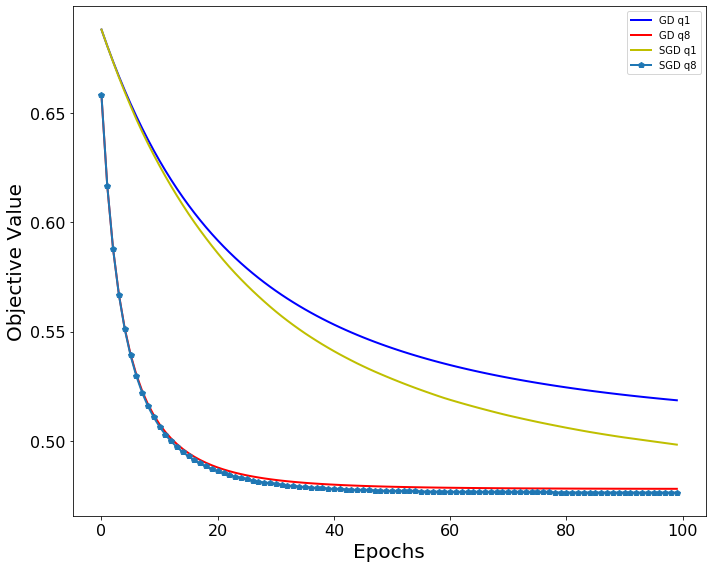

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
epochs_len = range(len(gd_q_1 ))

line0, = plt.plot(epochs_len, gd_q_1, '-b', LineWidth=2)
line1, = plt.plot(epochs_len, gd_q_8, '-r', LineWidth=2)
line2, = plt.plot(epochs_len, sgd_q_1, '-y', LineWidth=2)
line3, = plt.plot(epochs_len, sgd_q_8, '-p', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1,line2,line3], ['GD q1', 'GD q8','SGD q1','SGD q8'], fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig('compare.pdf', format='pdf')